# Setup

In [1]:
import pandas as pd
import numpy as np
# wizualizacje
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import itertools

from sklearn.metrics import mutual_info_score, adjusted_mutual_info_score, normalized_mutual_info_score
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression 
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer

# ustawienie szerokiego ekranu wyświetlacza JNotebook
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# opcje wyświetlania w Pandas
# - maks. 55 kolumn
# - maks. 101 wierszy
# - liczby w notacji dziesiętnej z czterema zerami po przecinku
pd.set_option('display.max_columns', 55)
pd.set_option('display.max_rows', 101)
pd.set_option('display.float_format', lambda x: f"{x:.4f}")

# opcje formatowania wykresów matplotlib
# - etykiety osi: bold
# - tekst: bold
# - domyślny rozmiar fontu=14
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['font.size'] = '14'

# Wczytanie danych

In [2]:
# Zadanie 3
filepath = r"C:\Users\pnaumczyk\Documents\Dane\Python_modelowanie_crashCourse\train.csv"
df = (
    pd.read_csv(filepath, sep=';')
    
    .assign(
        **{
             k: lambda df_, col = k: pd.to_datetime(df_[col])
                for k in [
                    'Kiedy jechał*ś?'
                ]
        },
        **{ k: lambda df_, col = k: pd.to_numeric(df_[col], downcast='float')
                for k in [
                    'Koszt podróży:'
                ]
        },
        **{ k: lambda df_, col = k: pd.to_numeric(df_[col], downcast='integer')
                for k in [
                    'Liczba minut opóźnienia na starcie:', 'Liczba minut opóźnienia na mecie:'
                ]
        }
    )
    
    .astype({
        **{ k: 'string' 
               for k in [
                   'Stacja początkowa:', 'Stacja końcowa:', 'Jak wrażenia z podróży? :D (nieobowiązkowe)', 'Uwagi (nieobowiązkowe):'
               ]            
        },
        **{ k: 'category' 
               for k in [
                   'Rodzaj pociągu:', 'Pora dnia:'
               ]            
        }
    })
    
    .rename(columns={
        'Kiedy jechał*ś?'         : 'data_przejazdu',
        'Stacja początkowa:'      : 'stacja_start',
        'Stacja końcowa:'         : 'stacja_finisz',
        'Rodzaj pociągu:'         : 'rodzaj_pociagu',
        'Uwagi (nieobowiązkowe):' : 'uwagi',
        'Koszt podróży:'          : 'cena_biletu',
        'Pora dnia:'              : 'pora_dnia_przejazdu',
        'Liczba minut opóźnienia na starcie:' : 'opoznienie_start',
        'Liczba minut opóźnienia na mecie:'   : 'opoznienie_finisz',
        'Jak wrażenia z podróży? :D (nieobowiązkowe)' : 'wrazenia'
    })
    
    .drop(columns=['wrazenia', 'uwagi'])
    .drop(index=[30, 50])
    
    .assign(
        pora_dnia_przejazdu = lambda df_: np.select(
        [
            (df_.pora_dnia_przejazdu.isnull() & df_.stacja_start.str.contains('Legionowo')).astype(bool),
            (df_.pora_dnia_przejazdu.isnull() & df_.stacja_finisz.str.contains('Legionowo')).astype(bool),
            (df_.pora_dnia_przejazdu.isnull() & df_.stacja_finisz.str.contains('Gdask')).astype(bool)
        ],
        [
            'rano',
            'popołudnie',
            'popołudnie'            
        ],
        df_.pora_dnia_przejazdu
    ))
    
    .reset_index(drop=True)
    
    .assign(
        czy_szkoda = lambda df_: np.select(
            [
                df_.opoznienie_finisz.gt(10) & df_.opoznienie_finisz.le(40),
                df_.opoznienie_finisz.gt(40)
            ],
            [
                1,
                2
            ],
            0
        ),
        
        wyplata_szkoda = lambda df_: np.where(
            df_.opoznienie_finisz.gt(10),
            df_.cena_biletu * np.exp(df_.opoznienie_finisz.div(100)) * df_.czy_szkoda,
            0.0
        )
    )
    
    .sort_values(by='data_przejazdu')
    .reset_index(drop=True)
)
df

,data_przejazdu,stacja_start,stacja_finisz,opoznienie_start,opoznienie_finisz,rodzaj_pociagu,cena_biletu,pora_dnia_przejazdu,czy_szkoda,wyplata_szkoda
0,2023-01-05,Warszawa Centralna,Gdańsk Oliwa,0,34,"""Zwykły"" InterCity",71.0000,popołudnie,1,99.7513
1,2023-01-10,Gdańsk Oliwa,Legionowo,0,10,"""Zwykły"" InterCity",71.0000,popołudnie,0,0.0000
2,2023-01-11,Legionowo Przystanek,Warszawa Centralna,0,3,Podmiejski / Regionalne,15.0000,rano,0,0.0000
3,2023-01-11,Warszawa Toruńska,Legionowo Przystanek,0,0,Podmiejski / Regionalne,15.0000,popołudnie,0,0.0000
4,2023-01-12,Warszawa Gdańska,Legionowo Przystanek,3,3,Podmiejski / Regionalne,15.0000,popołudnie,0,0.0000
...,...,...,...,...,...,...,...,...,...,...
98,2024-05-13,Gdańsk Oliwa,Warszawa Centralna,0,0,Pendolino,169.0000,rano,0,0.0000
99,2024-05-14,Warszawa Centralna,Gdańsk Oliwa,0,0,Pendolino,169.0000,popołudnie,0,0.0000
100,2024-05-21,Gdańsk Oliwa,Warszawa Centralna,26,38,Pendolino,169.0000,rano,1,247.1261
101,2024-05-23,Warszawa Centralna,Gdańsk Oliwa,0,0,"""Zwykły"" InterCity",71.0000,popołudnie,0,0.0000


# Spis treści
1. [Feature engineering](#fe)
2. [Informacja wzajemna](#mutual)

***
***

# <a id='fe'>Feature engineering</a> 
1. Jakie zmiany w danych byś przeprowadził na podstawie swojej analizy eksploracyjnej? Zastosuj je rozszerzając swój łańcuch 'method chaining'
2. Prześledź ich związek ze zmiennymi wyjaśnianymi

In [3]:
# Zadanie 1

filepath = r"C:\Users\pnaumczyk\Documents\Dane\Python_modelowanie_crashCourse\train.csv"
cats_dow = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Weekend"]
dow_dtype = pd.api.types.CategoricalDtype(categories=cats_dow, ordered=True)

miesiac_zima = ["January", "February", "December"]
miesiac_wiosna = ["March", "April", "May"]
miesiac_lato = ["June", "July", "August"]
miesiac_jesien = ["September", "October", "November"]

cats_season = ["wiosna", "lato", "jesien", "zima"]
season_dtype =  pd.api.types.CategoricalDtype(categories=cats_season, ordered=True)

cat_cols = [
    'pora_dnia_przejazdu',
    'dzien_tygodnia_cat', 
    'stacja_start_cat',  
    'stacja_finisz_cat', 
    'rodzaj_pociagu_cat', 
    'pora_roku_cat'
]
num_cols = [
    'opoznienie_start',
    'czy_szkoda',
    'wyplata_szkoda'
]


df = (
    pd.read_csv(filepath, sep=';')
    
    .assign(
        **{
             k: lambda df_, col = k: pd.to_datetime(df_[col])
                for k in [
                    'Kiedy jechał*ś?'
                ]
        },
        **{ k: lambda df_, col = k: pd.to_numeric(df_[col], downcast='float')
                for k in [
                    'Koszt podróży:'
                ]
        },
        **{ k: lambda df_, col = k: pd.to_numeric(df_[col], downcast='integer')
                for k in [
                    'Liczba minut opóźnienia na starcie:', 'Liczba minut opóźnienia na mecie:'
                ]
        }
    )
    
    .astype({
        **{ k: 'string' 
               for k in [
                   'Stacja początkowa:', 'Stacja końcowa:', 'Jak wrażenia z podróży? :D (nieobowiązkowe)', 'Uwagi (nieobowiązkowe):'
               ]            
        },
        **{ k: 'category' 
               for k in [
                   'Rodzaj pociągu:', 'Pora dnia:'
               ]            
        }
    })
    
    .rename(columns={
        'Kiedy jechał*ś?'         : 'data_przejazdu',
        'Stacja początkowa:'      : 'stacja_start',
        'Stacja końcowa:'         : 'stacja_finisz',
        'Rodzaj pociągu:'         : 'rodzaj_pociagu',
        'Uwagi (nieobowiązkowe):' : 'uwagi',
        'Koszt podróży:'          : 'cena_biletu',
        'Pora dnia:'              : 'pora_dnia_przejazdu',
        'Liczba minut opóźnienia na starcie:' : 'opoznienie_start',
        'Liczba minut opóźnienia na mecie:'   : 'opoznienie_finisz',
        'Jak wrażenia z podróży? :D (nieobowiązkowe)' : 'wrazenia'
    })
    
    .drop(columns=['wrazenia', 'uwagi'])
    .drop(index=[30, 50])
    
    .assign(
        pora_dnia_przejazdu = lambda df_: np.select(
        [
            (df_.pora_dnia_przejazdu.isnull() & df_.stacja_start.str.contains('Legionowo')).astype(bool),
            (df_.pora_dnia_przejazdu.isnull() & df_.stacja_finisz.str.contains('Legionowo')).astype(bool),
            (df_.pora_dnia_przejazdu.isnull() & df_.stacja_finisz.str.contains('Gdask')).astype(bool)
        ],
        [
            'rano',
            'popołudnie',
            'popołudnie'            
        ],
        df_.pora_dnia_przejazdu
    ))
    
    .reset_index(drop=True)
    
    .assign(
        czy_szkoda = lambda df_: np.select(
            [
                df_.opoznienie_finisz.gt(10) & df_.opoznienie_finisz.le(40),
                df_.opoznienie_finisz.gt(40)
            ],
            [
                1,
                2
            ],
            0
        ),
        
        wyplata_szkoda = lambda df_: np.where(
            df_.opoznienie_finisz.gt(10),
            df_.cena_biletu * np.exp(df_.opoznienie_finisz.div(100)) * df_.czy_szkoda,
            0.0
        )

    )
    
    .sort_values(by='data_przejazdu')
    .reset_index(drop=True)
    
    .assign(
        dzien_tygodnia = lambda df_: df_.data_przejazdu.dt.day_name().astype('category'),
        dzien_tygodnia_cat = lambda df_: np.where(
            df_.dzien_tygodnia.eq('Sunday') | df_.dzien_tygodnia.eq('Saturday') | df_.dzien_tygodnia.eq('Monday'),
            'Weekend',
            df_.dzien_tygodnia
        ),
        miesiac = lambda df_: df_.data_przejazdu.dt.month_name().astype('category'),
        pora_roku = lambda df_: np.select(
            [
                df_.miesiac.isin(miesiac_zima),
                df_.miesiac.isin(miesiac_wiosna),
                df_.miesiac.isin(miesiac_lato),
                df_.miesiac.isin(miesiac_jesien)
            ],
            [
                "zima",
                "wiosna",
                "lato",
                "jesien"
            ],
            "brak_danych"
        ),        
        stacja_start_cat = lambda df_: np.select(
            [
                df_.stacja_start.str.contains("Warszawa").astype(bool),
                df_.stacja_start.str.contains("Legionowo").astype(bool),
                (df_.stacja_start.str.contains("Gdańsk") | df_.stacja_start.str.contains("Gdask")).astype(bool)
            ],
            [
                "Warszawa",
                "Legionowo",
                "Gdańsk"
                
            ],
            "Inne"
        ),
        stacja_finisz_cat = lambda df_: np.select(
            [
                df_.stacja_finisz.str.contains("Warszawa").astype(bool),
                df_.stacja_finisz.str.contains("Legionowo").astype(bool),
                (df_.stacja_finisz.str.contains("Gdańsk") | df_.stacja_finisz.str.contains("Gdask")).astype(bool)
            ],
            [
                "Warszawa",
                "Legionowo",
                "Gdańsk"
                
            ],
            "Inne"
        ),  
        rodzaj_pociagu_cat = lambda df_: np.where(df_.rodzaj_pociagu.eq("EIC"), '"Zwykły" InterCity', df_.rodzaj_pociagu)
    )
    
    .astype({
        **{ k: 'category' 
               for k in [
                   'stacja_start_cat', 'stacja_finisz_cat', 'rodzaj_pociagu_cat'
               ]            
        },      
    })
    
    .assign(
        dzien_tygodnia_cat = lambda df_: df_.dzien_tygodnia_cat.astype(dow_dtype),
        pora_roku_cat = lambda df_: df_.pora_roku.astype(season_dtype)
    )
    
    .drop(columns=[
        'data_przejazdu', 'stacja_start', 'stacja_finisz', 'rodzaj_pociagu', 'cena_biletu', 'dzien_tygodnia', 'miesiac', 'pora_roku', 'opoznienie_finisz'
    ])
    
    .reindex(columns = cat_cols + num_cols)

)
df

,pora_dnia_przejazdu,dzien_tygodnia_cat,stacja_start_cat,stacja_finisz_cat,rodzaj_pociagu_cat,pora_roku_cat,opoznienie_start,czy_szkoda,wyplata_szkoda
0,popołudnie,Thursday,Warszawa,Gdańsk,"""Zwykły"" InterCity",zima,0,1,99.7513
1,popołudnie,Tuesday,Gdańsk,Legionowo,"""Zwykły"" InterCity",zima,0,0,0.0000
2,rano,Wednesday,Legionowo,Warszawa,Podmiejski / Regionalne,zima,0,0,0.0000
3,popołudnie,Wednesday,Warszawa,Legionowo,Podmiejski / Regionalne,zima,0,0,0.0000
4,popołudnie,Thursday,Warszawa,Legionowo,Podmiejski / Regionalne,zima,3,0,0.0000
...,...,...,...,...,...,...,...,...,...
98,rano,Weekend,Gdańsk,Warszawa,Pendolino,wiosna,0,0,0.0000
99,popołudnie,Tuesday,Warszawa,Gdańsk,Pendolino,wiosna,0,0,0.0000
100,rano,Tuesday,Gdańsk,Warszawa,Pendolino,wiosna,26,1,247.1261
101,popołudnie,Thursday,Warszawa,Gdańsk,"""Zwykły"" InterCity",wiosna,0,0,0.0000



ZMIENNE CIAGŁE



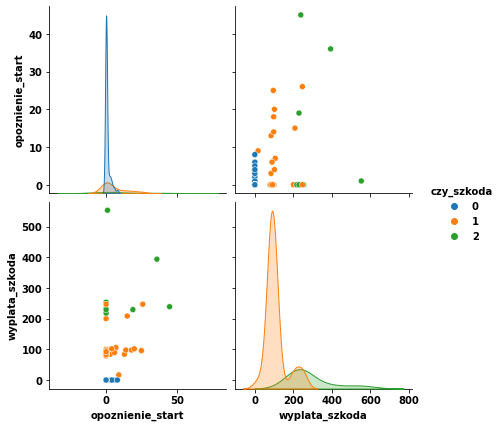

Spośród zmiennych ciągłych tylko opoznienie na starcie ma sens dla modelowania. Wyizolujmy ten związek i sprawdźmy dopasowanie krzywej wykładniczej:




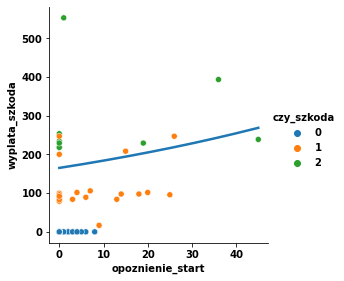

Współczynniki optymalne dopasowania krzywej wykładniczej: [0.01082047 5.10747606]
Równanie: y=e^0.011 * e^ (5.11 x)
Wdać, że ewentualny związek wykładniczy jest, acz niewielki


ZMIENNE KATEGORIALNE
Zobaczmy, jak wygląda związek między wyplatami, a opoznieniem na starcie w zależności od rodzaju pociągu



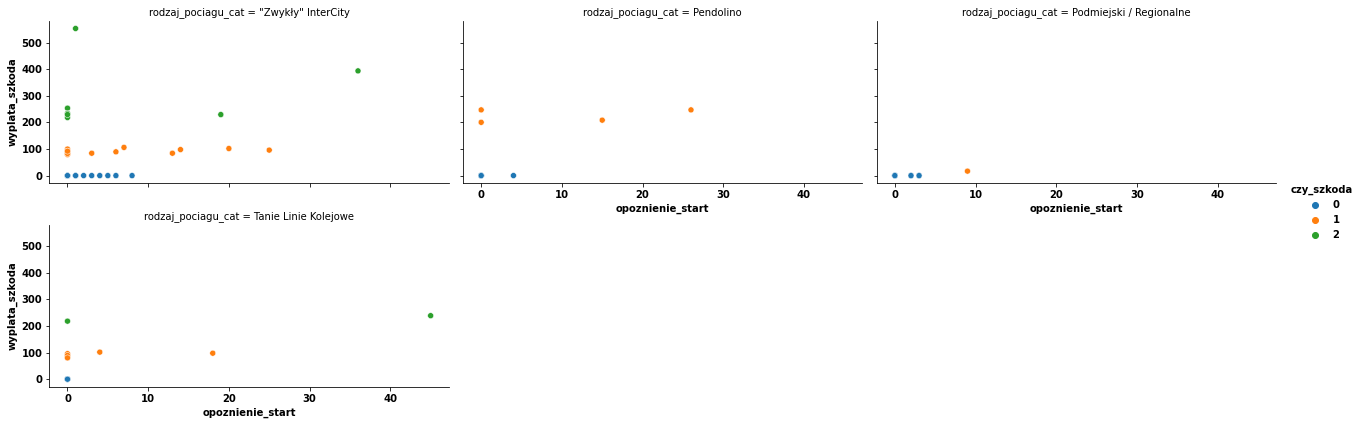

Zobaczmy, jak wygląda związek między wyplatami, a opoznieniem na starcie w zależności od pory dnia



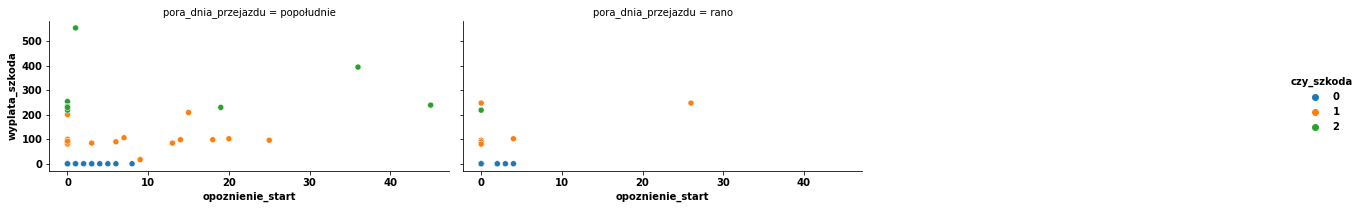

Zobaczmy, jak wygląda związek między wyplatami, a opoznieniem na starcie w zależności od stacji początkowej



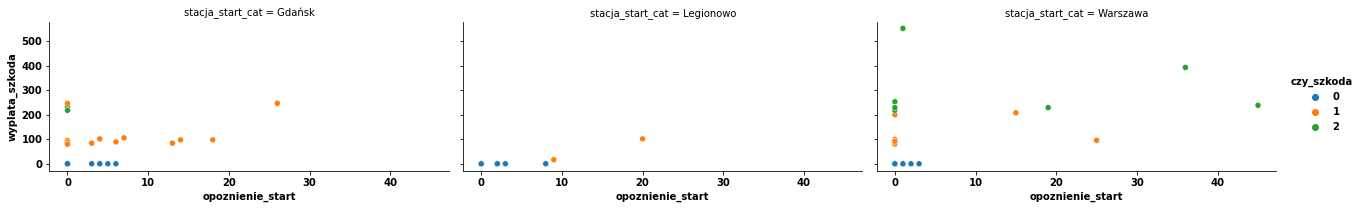

Zobaczmy, jak wygląda związek między wyplatami, a opoznieniem na starcie w zależności od stacji końcowej



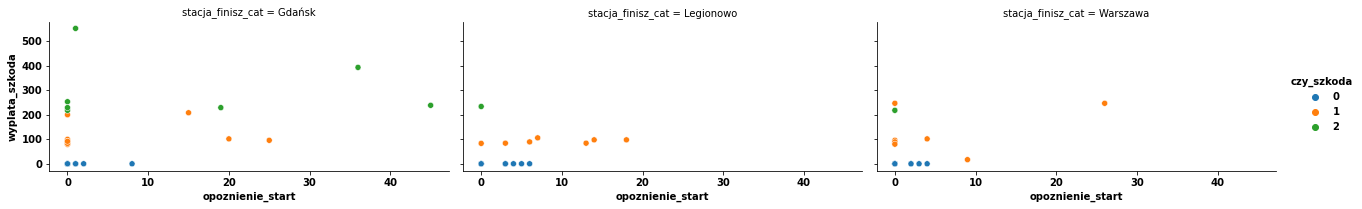

Zobaczmy, jak wygląda związek między wyplatami, a opoznieniem na starcie w zależności od dnia tygodnia przejazdu



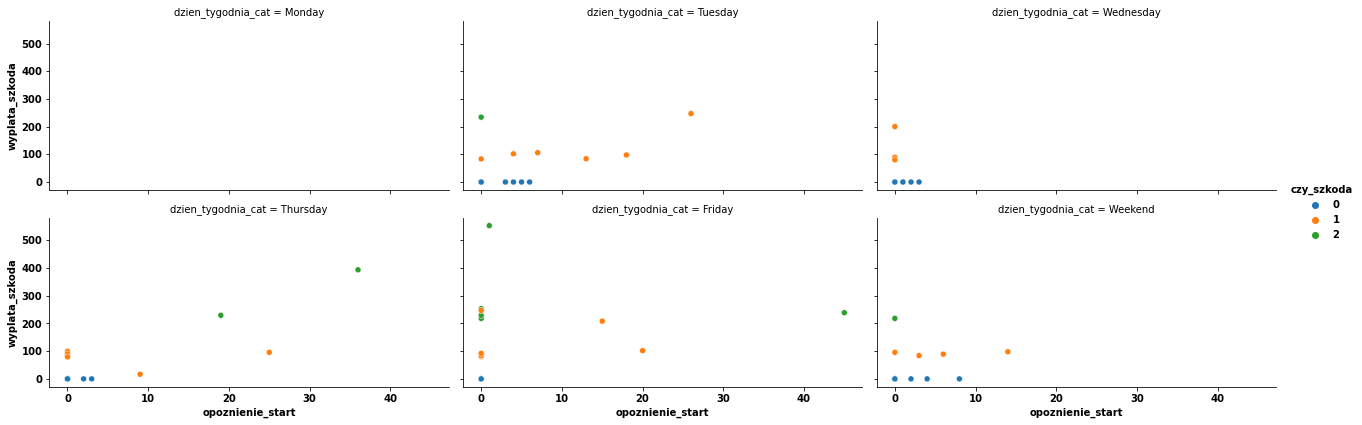

Zobaczmy, jak wygląda związek między wyplatami, a opoznieniem na starcie w zależności od pory roku



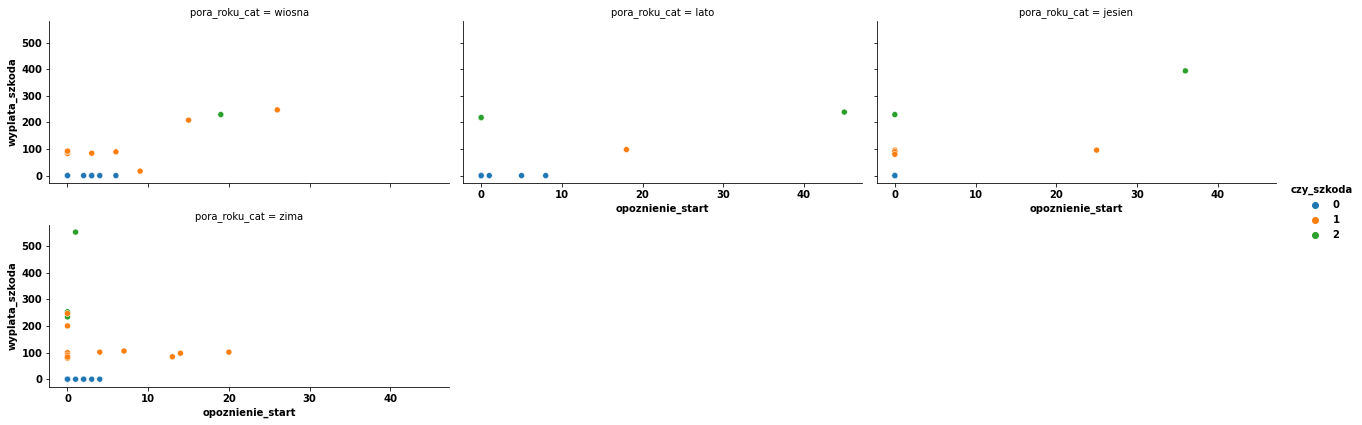

In [4]:
# Zadanie 2
# Wykres pairplot
print(f"\nZMIENNE CIAGŁE\n")
g = sns.pairplot(df, palette='tab10', height=3, hue='czy_szkoda')
plt.show()

print(f"Spośród zmiennych ciągłych tylko opoznienie na starcie ma sens dla modelowania. Wyizolujmy ten związek i sprawdźmy dopasowanie krzywej wykładniczej:\n\n")
# funkcja pomocnicza i warunki pomocnicze
def expFunc(x, a, b):
    return np.exp(a) * np.exp(b * x)
cols = ['wyplata_szkoda', 'opoznienie_start', 'czy_szkoda']
df_vis=df[cols]

# estymacja funkcji wkładniczej i zapis jej przebiegu do dataframe df_exp
popt = np.polyfit(df_vis.opoznienie_start, np.log1p(df_vis.wyplata_szkoda), 1, w=np.sqrt(df_vis.wyplata_szkoda))

xfit = np.linspace(0.01, max(df_vis.opoznienie_start), num=200)
yfit = expFunc(xfit, popt[1], popt[0])
df_exp = pd.DataFrame({'x':xfit, 'y':yfit})

# wykres punktowy bazowy
f = sns.relplot(
    df, 
    x='opoznienie_start', 
    y='wyplata_szkoda', 
    hue='czy_szkoda', 
    palette='tab10', height=4
)
# złapanie znacznika osi i dorzucenie wykresu logarytmicznego
ax = plt.gca()
sns.lineplot(
    data=df_exp,
    x='x', 
    y='y',
    ax=ax, 
    lw=2.5, 
    legend=False
)
plt.show()

print(
    f"Współczynniki optymalne dopasowania krzywej wykładniczej: {popt}\n"
    f"Równanie: y=e^{popt[0]:.3f} * e^ ({popt[1]:.2f} x)\n"
    f"Wdać, że ewentualny związek wykładniczy jest, acz niewielki\n\n"
    f"\nZMIENNE KATEGORIALNE\n"
    f"Zobaczmy, jak wygląda związek między wyplatami, a opoznieniem na starcie w zależności od rodzaju pociągu\n"
)

h = sns.relplot(df, x='opoznienie_start', y='wyplata_szkoda', hue='czy_szkoda', col_wrap=3, col='rodzaj_pociagu_cat', palette='tab10', height=3, aspect=2)
plt.show()

print(
    f"Zobaczmy, jak wygląda związek między wyplatami, a opoznieniem na starcie w zależności od pory dnia\n"
)
h1 = sns.relplot(df, x='opoznienie_start', y='wyplata_szkoda', hue='czy_szkoda', col_wrap=3, col='pora_dnia_przejazdu', palette='tab10', height=3, aspect=2)
plt.show()

print(
    f"Zobaczmy, jak wygląda związek między wyplatami, a opoznieniem na starcie w zależności od stacji początkowej\n"
)
h2 = sns.relplot(df, x='opoznienie_start', y='wyplata_szkoda', hue='czy_szkoda', col_wrap=3, col='stacja_start_cat', palette='tab10', height=3, aspect=2)
plt.show()

print(
    f"Zobaczmy, jak wygląda związek między wyplatami, a opoznieniem na starcie w zależności od stacji końcowej\n"
)
h3 = sns.relplot(df, x='opoznienie_start', y='wyplata_szkoda', hue='czy_szkoda', col_wrap=3, col='stacja_finisz_cat', palette='tab10', height=3, aspect=2)
plt.show()

print(
    f"Zobaczmy, jak wygląda związek między wyplatami, a opoznieniem na starcie w zależności od dnia tygodnia przejazdu\n"
)
h4 = sns.relplot(df, x='opoznienie_start', y='wyplata_szkoda', hue='czy_szkoda', col_wrap=3, col='dzien_tygodnia_cat', palette='tab10', height=3, aspect=2)
plt.show()

print(
    f"Zobaczmy, jak wygląda związek między wyplatami, a opoznieniem na starcie w zależności od pory roku\n"
)
h4 = sns.relplot(df, x='opoznienie_start', y='wyplata_szkoda', hue='czy_szkoda', col_wrap=3, col='pora_roku_cat', palette='tab10', height=3, aspect=2)
plt.show()

# <a id='mutual'>Informacja wzajemna</a> 
1. Policz wskaźniki informacji wzajemnej wszystkich (każda z każdą) zmiennych poprzez: 
    1. mutual_info_score, 
    2. adjusted_mutual_info_score, 
    3. normalized_mutual_info_score
2. Policz wskaźniki informacji wzajemej wszystkich (każda z każdą) zmiennych poprzez użycie mutual_info_classif oraz mutual_info_regression


C:\Users\pnaumczyk\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\cluster\_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
C:\Users\pnaumczyk\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\cluster\_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)
C:\Users\pnaumczyk\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\cluster\_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)
C:\Users\pnaumczyk\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\cluster\_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuo

<AxesSubplot:>

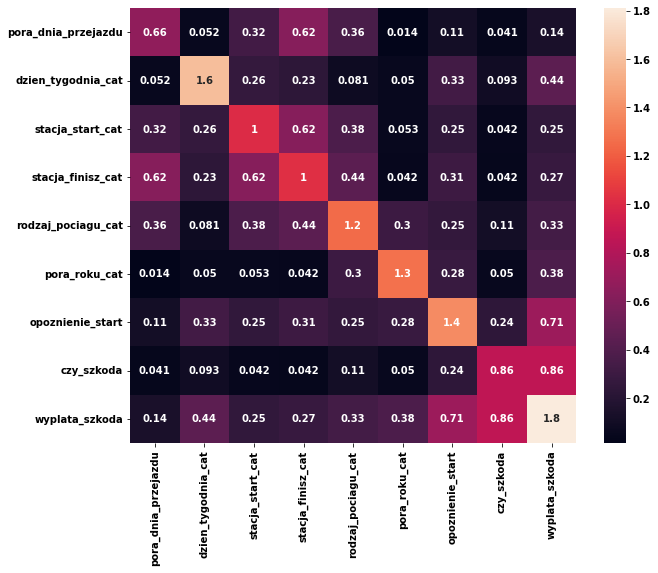

In [5]:
# Zadanie 1A
mi_scores = pd.DataFrame(index=df.columns, columns=df.columns, dtype=float)

for col in df.columns:
    for idx in df.columns:
        mi_scores.loc[idx, col] = mutual_info_score(df[idx], df[col])

plt.figure(figsize = (10,8))
sns.heatmap(mi_scores, annot=True)


C:\Users\pnaumczyk\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\cluster\_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
C:\Users\pnaumczyk\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\cluster\_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)
C:\Users\pnaumczyk\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\cluster\_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)
C:\Users\pnaumczyk\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\cluster\_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuo

<AxesSubplot:>

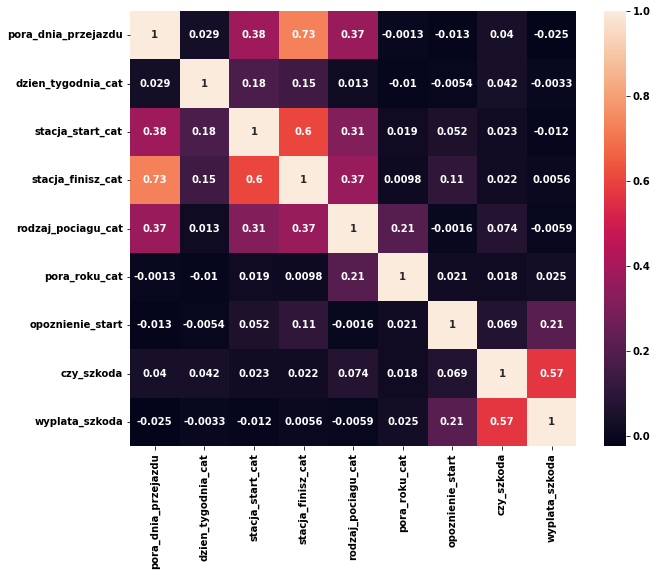

In [6]:
# Zadanie 1B
mi_adj_scores = pd.DataFrame(index=df.columns, columns=df.columns, dtype=float)

for col in df.columns:
    for idx in df.columns:
        mi_adj_scores.loc[idx, col] = adjusted_mutual_info_score(df[idx], df[col])

plt.figure(figsize = (10,8))
sns.heatmap(mi_adj_scores, annot=True)

C:\Users\pnaumczyk\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\cluster\_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
C:\Users\pnaumczyk\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\cluster\_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)
C:\Users\pnaumczyk\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\cluster\_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)
C:\Users\pnaumczyk\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\cluster\_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuo

<AxesSubplot:>

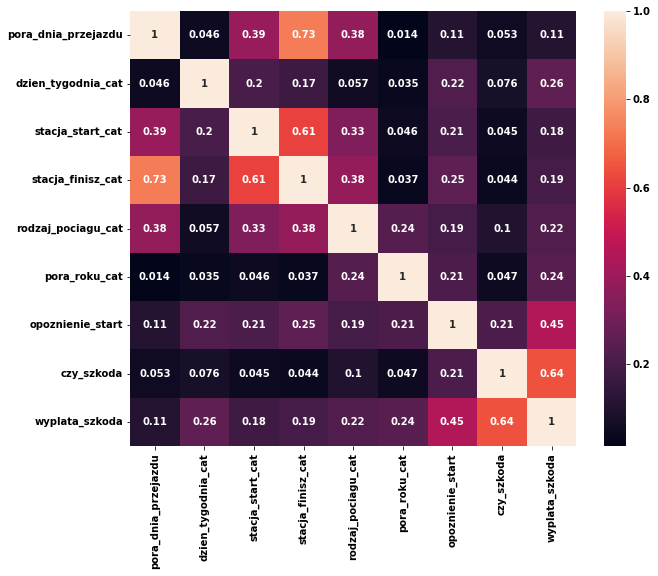

In [7]:
# Zadanie 1C
mi_norm_scores = pd.DataFrame(index=df.columns, columns=df.columns, dtype=float)

for col in df.columns:
    for idx in df.columns:
        mi_norm_scores.loc[idx, col] = normalized_mutual_info_score(df[idx], df[col])

plt.figure(figsize = (10,8))
sns.heatmap(mi_norm_scores, annot=True)

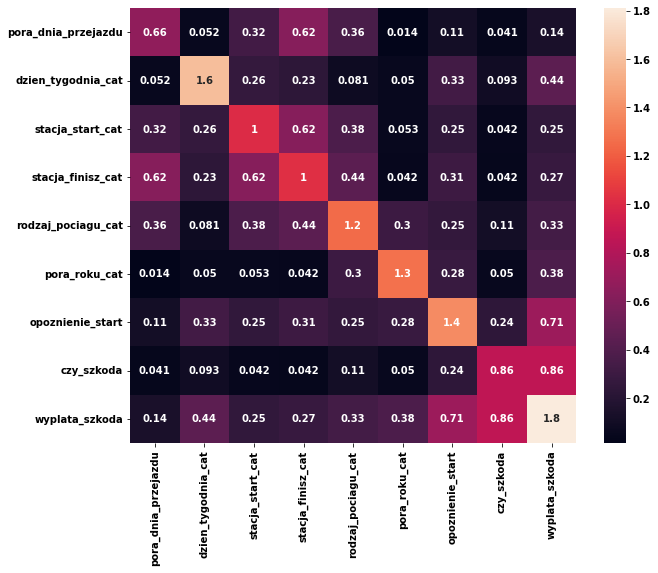

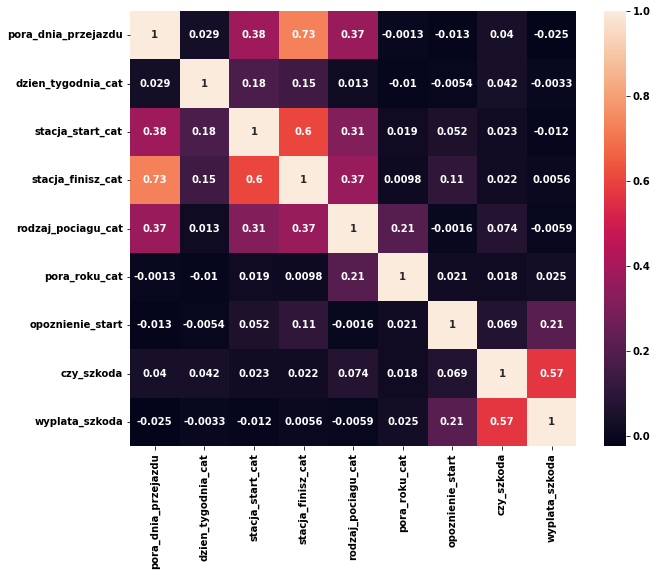

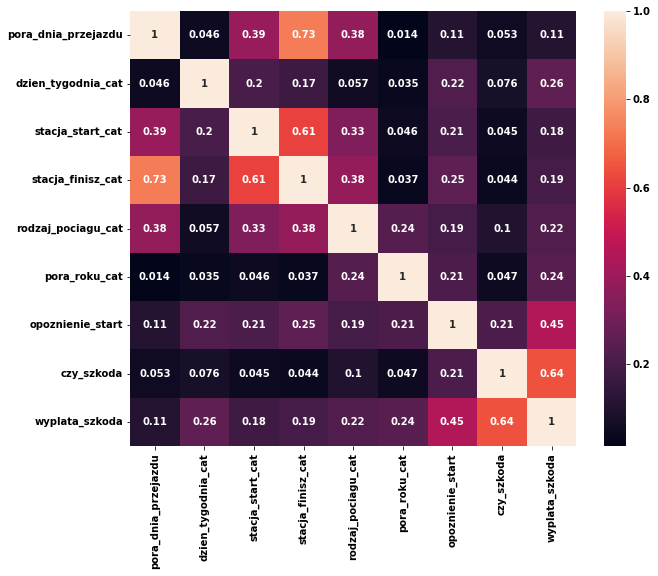

In [8]:
# Dla czytelności - zestawienie trzech w jednym oknie
plt.figure(figsize = (10,8))
sns.heatmap(mi_scores, annot=True)
plt.show()

plt.figure(figsize = (10,8))
sns.heatmap(mi_adj_scores, annot=True)
plt.show()

plt.figure(figsize = (10,8))
sns.heatmap(mi_norm_scores, annot=True)
plt.show()


[ColumnTransformer]  (1 of 2) Processing onehot_categorical, total=   0.0s
[ColumnTransformer] ... (2 of 2) Processing passthrough, total=   0.0s


<AxesSubplot:>

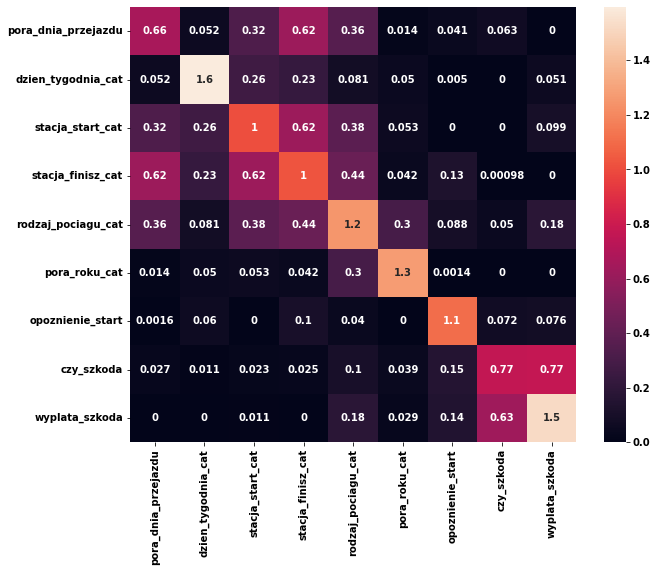

In [9]:
# Zadanie 2
num_cols = ['opoznienie_start', 'czy_szkoda', 'wyplata_szkoda']
cat_cols = ['pora_dnia_przejazdu', 'dzien_tygodnia_cat', 'stacja_start_cat', 'stacja_finisz_cat', 'rodzaj_pociagu_cat', 'pora_roku_cat']
cats = [
    ['rano', 'popołudnie'],
    ['Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Weekend'],
    ['Gdańsk', 'Legionowo', 'Warszawa'],
    ['Gdańsk', 'Legionowo', 'Warszawa'],
    ['Podmiejski / Regionalne', 'Tanie Linie Kolejowe', '"Zwykły" InterCity', 'Pendolino'],
    ['wiosna',  'lato', 'jesien', 'zima']
]


column_trans = ColumnTransformer(
    [
        (
            "onehot_categorical",
            OrdinalEncoder(categories=cats), 
            cat_cols
        ),
        (
            "passthrough",
            'passthrough',
            num_cols
        )
    ],
    verbose=True
)

X_coded = column_trans.fit_transform(df)
transformer_feature_names = []
for name, transformer, features in column_trans.transformers_:
    if hasattr(transformer, 'get_feature_names'):
        transformer_feature_names.extend(
            [f"{name}_{f}" for f in transformer.get_feature_names(features)]
        )
    else:
        transformer_feature_names.extend(features)
df_coded = pd.DataFrame(X_coded, columns=transformer_feature_names)    

mi_scores_target = pd.DataFrame(index=df_coded.columns, columns=df_coded.columns, dtype=float)
mask_cat = [True if col in cat_cols else False for col in df_coded.columns]

for col in df_coded.columns:
    if col in cat_cols:
        mi_scores_target.loc[col, :] = mutual_info_classif(
            df_coded,
            df_coded[col],
            discrete_features=mask_cat,
            random_state=0
        )
    else:
        mi_scores_target.loc[col, :] = mutual_info_regression(
            df_coded,
            df_coded[col],
            discrete_features=mask_cat,
            random_state=0
        ) 

plt.figure(figsize = (10,8))
sns.heatmap(mi_scores_target, annot=True)